In [5]:
import os
import numpy as np
import SimpleITK as sitk
import glob
import matplotlib.pyplot as plt
import cv2
from skimage import measure

data_dir = 'nnUNet_raw_data_base/nnUNet_test_data/test_img_in_nii_example/'

for d in os.listdir(data_dir):
    if 'img' in d and '.nii.gz' in d :
        img_path = data_dir + d
    if 'seg' in d  and '.nii.gz' in d:
        seg_path = data_dir + d        
print(img_path,'\n\n', seg_path)

nnUNet_raw_data_base/nnUNet_test_data/test_img_in_nii_example/Pancreas_0001_img_0000.nii.gz 

 nnUNet_raw_data_base/nnUNet_test_data/test_img_in_nii_example/Pancreas_0001_nnunet_seg.nii.gz


In [6]:
from pre_processing.renal_hull import save_hull_of_parenchyma_into_nii
targ_path = 'nnUNet_raw_data_base/nnUNet_test_data/test_img_in_nii_example/Pancreas_0001_kidney_seg_total.nii.gz'
save_hull_of_parenchyma_into_nii(seg_path,targ_path )

nnUNet_raw_data_base/nnUNet_test_data/test_img_in_nii_example/Pancreas_0001_kidney_seg_total.nii.gz saved


(48, 440, 440)


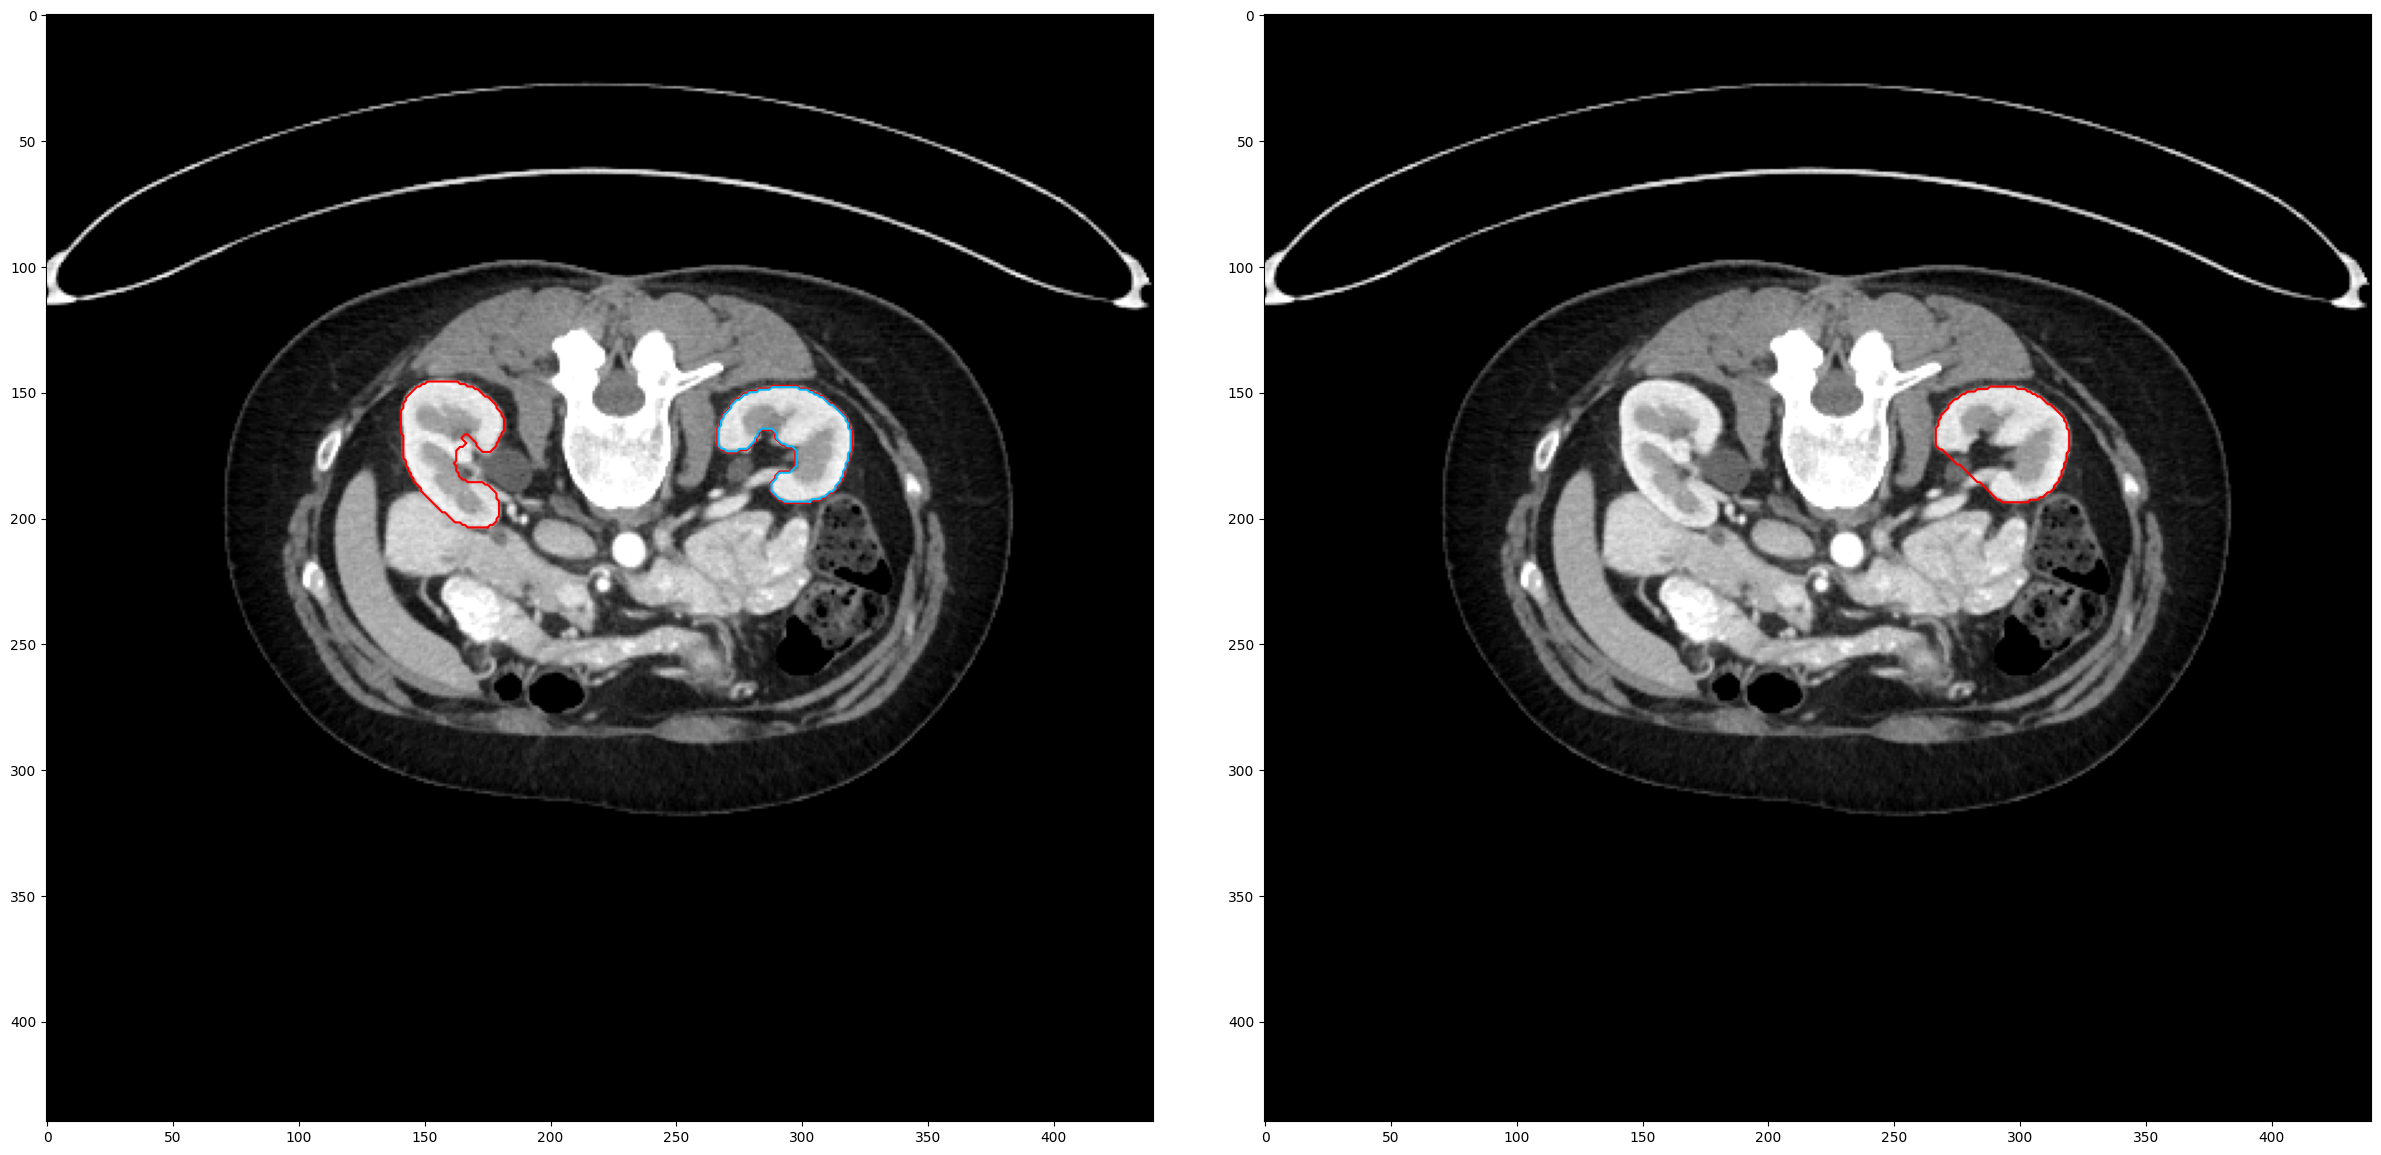

In [16]:
ct_sitk = sitk.ReadImage(img_path)
ct_array =  sitk.GetArrayFromImage(ct_sitk)  
seg_sitk = sitk.ReadImage(seg_path)
seg_array =  sitk.GetArrayFromImage(seg_sitk) 
print(seg_array.shape)
# seg_array[seg_array == 2] =0  # right kidney is left   
# seg_array[seg_array == 1] =0 # left kidney is left

hu_min, hu_max = -135, 215
ct_array[ct_array<hu_min] = hu_min
ct_array[ct_array>hu_max] = hu_max 

z_idx = 30
fig, ax = plt.subplots(1, 2, figsize=(30, 15))
plt.subplots_adjust(wspace=0.1)    
ax[0].imshow(ct_array[z_idx ,:,:], cmap='gray')    
ax[1].imshow(ct_array[z_idx ,:,:], cmap='gray')   

contours_1 = measure.find_contours(seg_array[z_idx,:,:], 0.5)
for n, contour1 in sorted(enumerate(contours_1), reverse = True):
    ax[0].plot(contour1[:, 1], contour1[:, 0], linewidth=1.5, color='red')      #      '#00bcffff'      
contours_2 = measure.find_contours(seg_array[z_idx,:,:], 1.5)
for n, contour2 in sorted(enumerate(contours_2), reverse = True):
    ax[0].plot(contour2[:, 1], contour2[:, 0], linewidth=1.5, color='#00bcffff')
    
    
seg_slice =  seg_array[z_idx ,:,:]
# seg_slice[seg_slice==2] = 0

seg_slice = seg_slice.astype("uint8")
_, thresh = cv2.threshold(seg_slice, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
contours, hierarchy = cv2.findContours(thresh, 3, 2)
cnt = contours[0]
hull = cv2.convexHull(cnt)
hull_mask = np.zeros(seg_slice.shape)
for j in range(np.min(hull[:,:]-1), np.max(hull[:,:]+1)):
    for k in range(np.min(hull[:,:]-1), np.max(hull[:,:]+1)):
        dist = cv2.pointPolygonTest(hull, (k, j), False)
        if dist >=0:
            hull_mask[j,k]=1
            
contours_hull = measure.find_contours(hull_mask, 0.5)
for n, contour_hull in sorted(enumerate(contours_hull), reverse = True):
    ax[1].plot(contour_hull[:, 1], contour_hull[:, 0], linewidth=1.5, color='red')      #      '#00bcffff'    


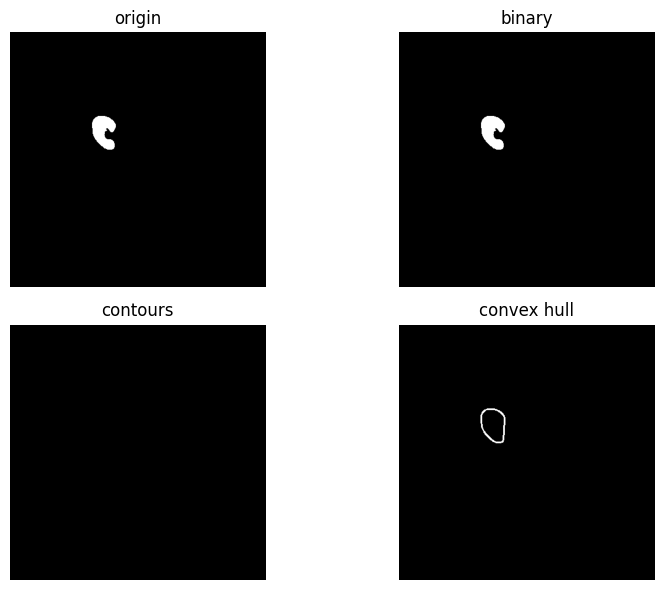

In [12]:
seg_slice =  seg_array[z_idx ,:,:]
seg_slice[seg_slice==2] = 0
seg_slice = seg_slice.astype("uint8")
ret, imgBin  = cv2.threshold(seg_slice, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

contours, hierarchy  = cv2.findContours(imgBin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)  # 寻找所有的轮廓
hullAll = []  # 所有的凸包
for i in range(len(contours)):
    hull = cv2.convexHull(contours[i], False)  # 计算轮廓 contours[i] 的凸包
    hullAll.append(hull)

colorContours = (0, 255, 0)  # 设置轮廓的颜色
colorConvexHull = (255, 255, 255)  # 设置凸包的颜色
imgContours = np.zeros(imgBin.shape, np.uint8)
# for i in range(len(contours)):  # 绘制轮廓线
#     cv2.drawContours(imgContours, contours, i, colorContours, 2, 8, hierarchy)
imgDrawing = imgContours.copy()
# for i in range(len(contours)):  # 绘制凸包线
#     cv2.drawContours(imgDrawing, hullAll, i, colorConvexHull, 2, 8)
    
cv2.drawContours(imgDrawing, hullAll, -1, colorConvexHull, 2, 8)

plt.figure(figsize=(9, 6))
plt.subplot(221), plt.axis('off'), plt.title("origin")
plt.imshow(cv2.cvtColor(imgBin, cv2.COLOR_BGR2RGB))
plt.subplot(222), plt.title("binary"), plt.axis('off')
plt.imshow(imgBin, cmap='gray', vmin=0, vmax=255)
plt.subplot(223), plt.title("contours"), plt.axis('off')
plt.imshow(cv2.cvtColor(imgContours, cv2.COLOR_BGR2RGB))
plt.subplot(224), plt.title("convex hull"), plt.axis('off')
plt.imshow(cv2.cvtColor(imgDrawing, cv2.COLOR_BGR2RGB))
plt.tight_layout()
plt.show()


In [4]:
len(contours)

3